In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from keras.utils import np_utils
from skimage.io import imread
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


In [2]:
def get_img_size(path):
    for img in os.listdir(path):
        if img.endswith('.jpg') or img.endswith('.png'):
            shape = imread(path+img).shape
            
    return shape[0], shape[1], shape[2]


def get_set_images(path, flatten=True):
    width, height, channels = get_img_size(path)
    n_imgs = len(os.listdir(path))

    if flatten:
        image_set = np.zeros((n_imgs, width*height*channels), dtype=np.float32)
    else:
        image_set = np.zeros((n_imgs, width, height, channels), dtype=np.float32)

    for i, img in enumerate(os.listdir(path)):
        if img.endswith('.jpg') or img.endswith('.png'):
            if flatten:
                image_set[i] = imread(path+img).flatten()
            else:
                image_set[i] = imread(path+img)

    return image_set

In [3]:
train_path = "dataset/train/"
test_path = "dataset/test/"
classes = ["non-vehicles", "vehicles"]

nb_classes = 2
normalization = 1
flatten = 1

img_rows, img_colums, img_c = get_img_size(train_path+"non-vehicles/")

In [4]:
nv_train = get_set_images(train_path+"non-vehicles/", flatten)
v_train = get_set_images(train_path+"vehicles/", flatten)

if normalization:
    nv_train /= 255
    v_train /= 255

# Matrix where we will store all images:
train_data = np.vstack((nv_train, v_train))

In [5]:
train_data = np.array(train_data)
print(train_data.shape)

labels = np.zeros((train_data.shape[0]), dtype=int)
labels[:nv_train.shape[0]] = 0
labels[nv_train.shape[0]:] = 1

(15009, 12288)


In [6]:
train_data = [train_data, labels]

(X, y) = (train_data[0], train_data[1])

In [7]:
X, y = shuffle(X, y, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

if flatten:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_colums, img_c)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_colums, img_c)

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

## Some examples

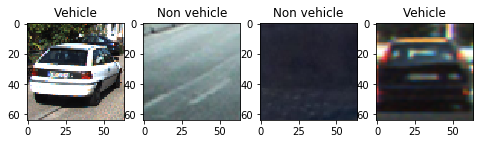

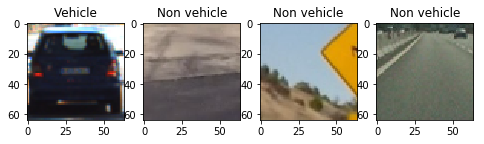

In [8]:
n_imgs = 8
imgs = np.random.randint(X_train.shape[0], size=n_imgs)

n_axes = 4
figure, axes = plt.subplots(1, n_axes, figsize=(8,4))

c_ax = 0
for count, i in enumerate(imgs):
    if Y_train[i][0]:
        axes[c_ax].set_title('Non vehicle')
    else:
        axes[c_ax].set_title('Vehicle')
        
    axes[c_ax].imshow(X_train[i])
    if c_ax < n_axes-1:
        c_ax += 1
    else:
        c_ax = 0
        if count < n_imgs-1:
            figure, axes = plt.subplots(1, n_axes, figsize=(8,4))

        

# Model

In [9]:
from keras.models import Sequential
from keras.layers import Convolution2D, Activation, MaxPooling2D, Dropout, Dense, Flatten
from keras.utils import plot_model

batch_size = 32

nb_epoch = 10
nb_filters = 32
nb_pool = 2
nb_conv = 3
dropout = 0.2

input_shape = (img_rows, img_colums, img_c)
model = Sequential()

model.add(Convolution2D(nb_filters, (nb_conv, nb_conv), input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, (nb_conv, nb_conv)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=["accuracy"])

In [10]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
          validation_data=(X_test, Y_test))

Train on 12007 samples, validate on 3002 samples
Epoch 1/10
12007/12007 [==============================] - 31s - loss: 0.3277 - acc: 0.8644 - val_loss: 0.1256 - val_acc: 0.9510
Epoch 2/10
12007/12007 [==============================] - 13s - loss: 0.1121 - acc: 0.9605 - val_loss: 0.1580 - val_acc: 0.9417
Epoch 3/10
12007/12007 [==============================] - 13s - loss: 0.0688 - acc: 0.9770 - val_loss: 0.0523 - val_acc: 0.9813
Epoch 4/10
12007/12007 [==============================] - 13s - loss: 0.0544 - acc: 0.9813 - val_loss: 0.0435 - val_acc: 0.9827
Epoch 5/10
12007/12007 [==============================] - 14s - loss: 0.0447 - acc: 0.9863 - val_loss: 0.0393 - val_acc: 0.9853
Epoch 6/10
12007/12007 [==============================] - 13s - loss: 0.0399 - acc: 0.9874 - val_loss: 0.0504 - val_acc: 0.9827
Epoch 7/10
12007/12007 [==============================] - 13s - loss: 0.0356 - acc: 0.9886 - val_loss: 0.0381 - val_acc: 0.9850
Epoch 8/10
12007/12007 [==============================]

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 60, 60, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28800)             0         
__________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


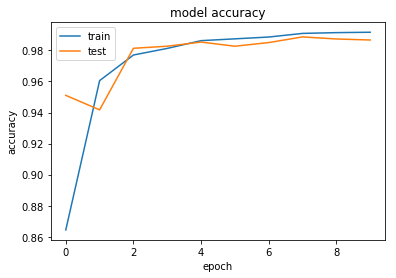

In [12]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
test_images_only_vehic = get_set_images(test_path+"vehicles/", False)
test_images_not_vehic = get_set_images(test_path+"non-vehicles/", False)
if normalization:
    test_images_only_vehic /= 255
    test_images_not_vehic /= 255


In [14]:
pred_vehic = model.predict(test_images_only_vehic)
pred_non_vehic = model.predict(test_images_not_vehic)

rounded_vehic = [int(round(x[1])) for x in pred_vehic]
rounded_non_vehic = [int(round(x[0])) for x in pred_non_vehic]

# Window implementation

In [15]:
def draw_boxes(img, bboxes, color=(0, 255, 0), thick=3):
    # a = draw_boxes(img,[[(384,0),(510,128)]])
    
    # Make a copy of the image
    draw_img = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    
    # Return the image copy with boxes drawn
    return draw_img


def search_windows(img, windows, confidence=0.5):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    predictions = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        test_img = test_img.astype("float32")
        test_img /= 255
        test_img = np.expand_dims(test_img, axis=0)        
        
        prediction = model.predict(test_img)
        
        if prediction[0][1] > confidence:
            on_windows.append(window)
    
    #4) Return windows for positive detections
    return on_windows 


def slide_window(img, x_start_stop=[None, None], 
                 y_start_stop=[None,None], xy_window=(64,64),
                 xy_overlap=(0.5, 0.5)):
    
    # Compute the span of the region 
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Calc how many pixels there are in each step in x and y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Calc the number of windows in x and y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan - nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan - ny_buffer)/ny_pix_per_step)
    
    # Init the list to append the window positions
    window_list = []
    
    # Loop to find x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    
    # Return the image
    return img

In [22]:
def detect_car(image_to_process, confidence_degree=0.9):
    draw_image = np.copy(image_to_process)
    
    heat = np.zeros_like(image_to_process[:,:,0]).astype(np.float)
    
    windows = slide_window(image_to_process,
                           x_start_stop=[0, 1280], 
                           y_start_stop=[380, 680], 
                           xy_window=(128, 128), 
                           xy_overlap=(0.65, 0.65))
        
    #draw_image = draw_boxes(draw_image, windows, color=(0, 255, 255))
            
    hot_windows = search_windows(image_to_process, windows, confidence_degree)
    # Add heat to each box in box list
    add_heat(heat, hot_windows)
    
    windows = slide_window(image_to_process,
                           x_start_stop=[0, 1280], 
                           y_start_stop=[390, 620], 
                           xy_window=(96, 96), 
                           xy_overlap=(0.65, 0.65))
        
    #draw_image = draw_boxes(draw_image, windows, color=(0, 255, 0))
            
    hot_windows = search_windows(image_to_process, windows, confidence_degree)
    # Add heat to each box in box list
    add_heat(heat, hot_windows)
    
    windows = slide_window(image_to_process,
                           x_start_stop=[0, 1280], 
                           y_start_stop=[390, 560], 
                           xy_window=(72, 72), 
                           xy_overlap=(0.65, 0.65))
        
    #draw_image = draw_boxes(draw_image, windows, color=(255, 0, 255))
            
    hot_windows = search_windows(image_to_process, windows, confidence_degree)
    # Add heat to each box in box list
    add_heat(heat, hot_windows)
    
    
    windows = slide_window(image_to_process,
                           x_start_stop=[0, 1280], 
                           y_start_stop=[390, 500], 
                           xy_window=(64, 64), 
                           xy_overlap=(0.65, 0.65))
        
    #draw_image = draw_boxes(draw_image, windows, color=(255, 0, 0))
            
    hot_windows = search_windows(image_to_process, windows, confidence_degree)
    # Add heat to each box in box list
    add_heat(heat, hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_labeled_bboxes(draw_image, labels) 
    
    return draw_image, heatmap, labels




ValueError: not enough values to unpack (expected 3, got 2)

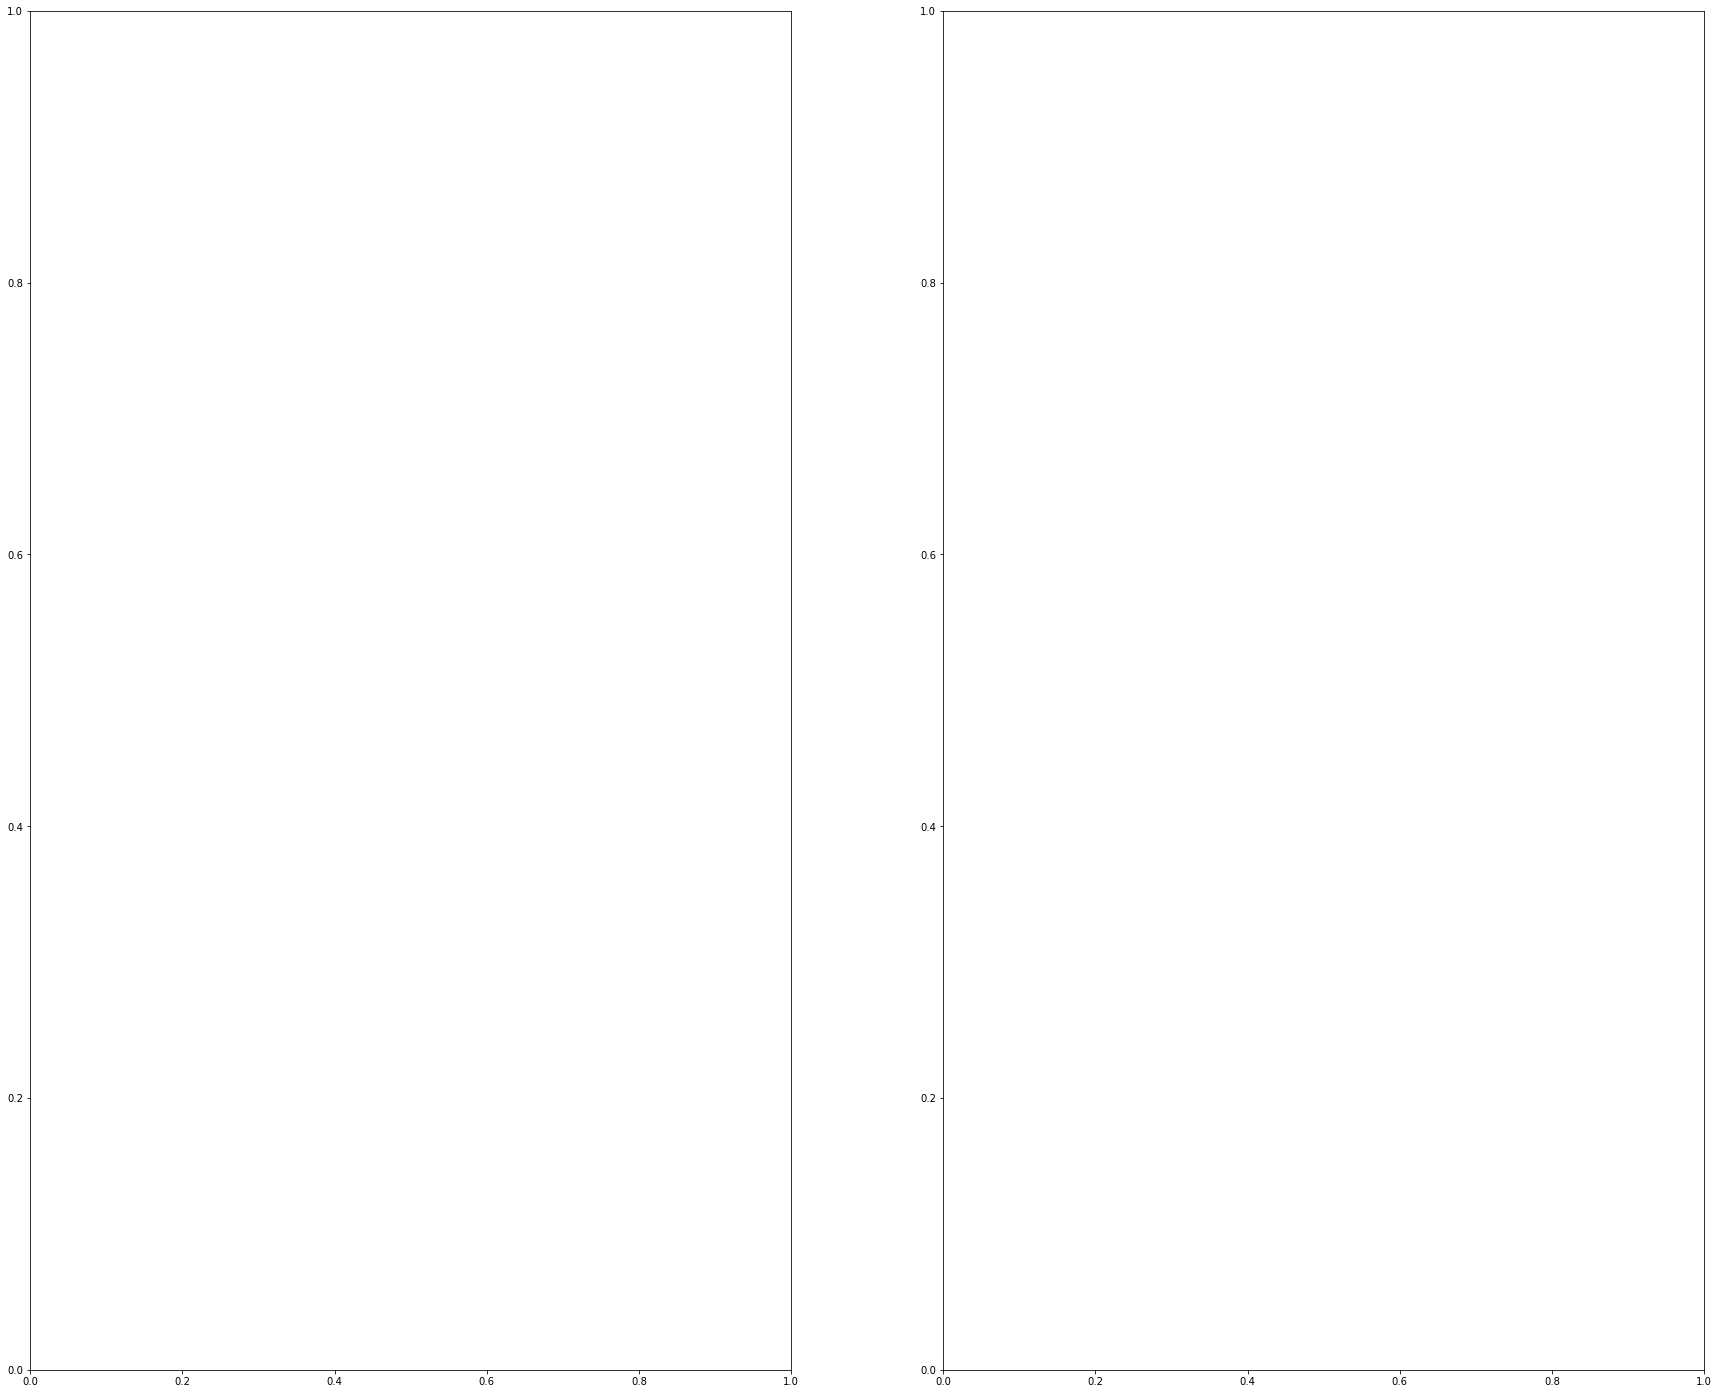

In [23]:
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label

#image = image.astype(np.float32)/255


image = mpimg.imread('test_imgs/test1.jpg')


confidence_degree = 0.8

detected_car_image, detected_car_heatmap, _ = detect_car(image, confidence_degree)

figure, (detected_car_image_plot, detected_car_heatmap_plot) = plt.subplots(1, 2, figsize=(30,25))
        
detected_car_image_plot.set_title('Detected cars')
detected_car_image_plot.imshow(detected_car_image)

detected_car_heatmap_plot.set_title('Heatmap')
detected_car_heatmap_plot.imshow(detected_car_heatmap)

# detected_car_labales_plot.set_title('Labels')
# detected_car_labales_plot.imshow(detected_car_labales[0], cmap='gray')

In [18]:
from moviepy.editor import VideoFileClip

def process_image(temp_image):
    result = detect_car(temp_image)
    return result[0]

video_output = 'test_videos/final_2.mp4'
clip = VideoFileClip("test_videos/output1.mp4")
output_clip = clip.fl_image(process_image)

%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_videos/final_2.mp4
[MoviePy] Writing video test_videos/final_2.mp4


  2%|▏         | 22/1093 [00:28<22:22,  1.25s/it]

KeyboardInterrupt: 